# Parte 1 – Entendimento do Problema: Campanha de Marketing Bancário

### Definição do Alvo e Tipo de Problema
Neste projeto, trabalhamos com o dataset "Bank Marketing". A **variável alvo (target)** é a coluna identificada como `Class`. No mundo real, ela representa a decisão final do cliente: se ele **assinou (yes/2)** ou **não assinou (no/1)** o depósito a prazo oferecido pelo banco.

Trata-se de um problema clássico de **classificação binária**, pois existem apenas duas classes possíveis de saída: o cliente assinou ou não.

### Análise de Erros
Neste contexto, a interpretação dos erros do modelo é:
* **Falso Positivo (FP):** O modelo prevê que o cliente vai aceitar o depósito, o banco gasta recursos ligando para ele, mas ele recusa. O custo aqui é o tempo do operador.
* **Falso Negativo (FN):** O modelo prevê que o cliente *não* vai aceitar e recomenda não ligar, mas o cliente teria aceitado se fosse abordado. O custo aqui é o **Custo de Oportunidade**, ou seja, perda de lucro do banco.

Considerando que o custo de uma ligação é baixo comparado ao lucro gerado por um investimento do cliente, o **erro mais grave neste problema é o Falso Negativo**. Por isso, durante a modelagem, priorizamos métricas que valorizam a captura de clientes positivos (Recall), aceitando uma taxa um pouco maior de Falsos Positivos para garantir a cobertura do mercado.

### Dados, Usuário e Balanceamento
O **usuário final** deste modelo é a equipe de **Marketing e Operações do Banco**, especificamente os gerentes de campanhas e o call center, que usarão a lista gerada para priorizar as ligações.

Os dados disponíveis são mistos, contendo variáveis **numéricas** (como `age`, `balance`, `duration`, `day`), **categóricas** (como `job`, `education`) e **binárias** (como `default`, `housing`, `loan`).

Uma característica crítica deste dataset é que as **classes estão desbalanceadas**. Verificamos isso através da contagem de valores (`value_counts`) na variável alvo, onde constatamos que a grande maioria dos registros (~88%) pertence à classe "não" (1), enquanto a minoria (~12%) pertence à classe "sim" (2). Isso exigiu técnicas de tratamento como o ajuste de pesos no modelo (`class_weight='balanced'`).

### Manutenção
Se o modelo errar, quem é afetado diretamente é o **Banco**, financeiramente, e o **Cliente** que pode receber ligações indesejadas.

Se o dataset fosse atualizado constantemente, o modelo sofreria de **Concept Drift** (mudança de conceito). O comportamento financeiro das pessoas muda com a inflação, crises econômicas ou novas tecnologias. Portanto, seria necessário implementar um pipeline de **monitoramento contínuo** e **retreino periódico**, por exemplo mensalmente, para que o modelo aprenda os novos padrões de comportamento do consumidor.

Por fim, o **cuidado ético** é fundamental. O modelo utiliza dados sensíveis como idade e salario. É necessário garantir que o algoritmo não discrimine grupos específicos (ex: negar atendimento a idosos ou por piso salarial) e que esteja em conformidade com leis de proteção de dados (como a LGPD), garantindo que os clientes consentiram o uso de seus dados para fins de marketing.

In [1]:
from sklearn.datasets import fetch_openml

bank = fetch_openml('bank-marketing', version=1, as_frame=True)

In [2]:
import pandas as pd

df:pd.DataFrame = bank.frame 

feature_names = {'V1':'age', 'V2':'job', 'V3': 'marital', 'V4': 'education', 'V5': 'default', 'V6': 'balance', 
                 'V7': 'housing', 'V8': 'loan', 'V9': 'contact', 'V10': 'day', 'V11': 'month', 'V12': 'duration', 
                 'V13': 'campaign', 'V14': 'pdays', 'V15': 'previous', 'V16': 'poutcome'}

df = df.rename(columns=feature_names)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  Class      45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
df['Class'].value_counts(normalize=True) * 100

Class
1    88.30152
2    11.69848
Name: proportion, dtype: float64

In [6]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Class        0
dtype: int64

## 2. Preparação dos Dados e Feature Engineering

Para melhorar a performance do modelo, as seguintes transformações foram aplicadas:

### Remoção de Data Leakage
A coluna `duration` (duração da chamada) foi **removida**.
* **Motivo:** Esta informação só é conhecida *após* a ligação ser feita. Usá-la para prever "para quem ligar" criaria um modelo irrealista que falharia em produção.

### Engenharia de Atributos
1.  **Transformação Log-Modulus (`balance_logmod`):**
    * A coluna de saldo (`balance`) possuía valores negativos e muitos zeros.
    * Aplicamos a fórmula $sign(x) \times \log(|x|+1)$ para normalizar a distribuição sem perder a distinção entre devedores e poupadores.
2.  **Intensidade de Interação (`interaction_intensity`):**
    * Criamos uma métrica que relaciona o número de contatos atuais com o histórico passado para medir a "fadiga" do cliente.
3.  **Tentativas de Contato com o Cliente(`is_contated`):**
    * Reformulamos a coluna `pdays` para expressar o "numero mágico" que ela possue, onde "-1" significa que o banco nunca ligou para esse cliente e os demais o banco ja ligou.
4.  **Codificação Categórica:**
    * Variáveis como `job`, `education` e `marital` foram transformadas via **One-Hot Encoding** ou **Ordinal Encoding** para serem processadas matematicamente.
5. **Remoção de Colunas com Alta Correlação:**
    * As colunas com alta grau de correlação, significa que essas colunas expressam a mesma "ideia" de uma outra coluna, assim removemos pra não termos ruidos no treinamento. 

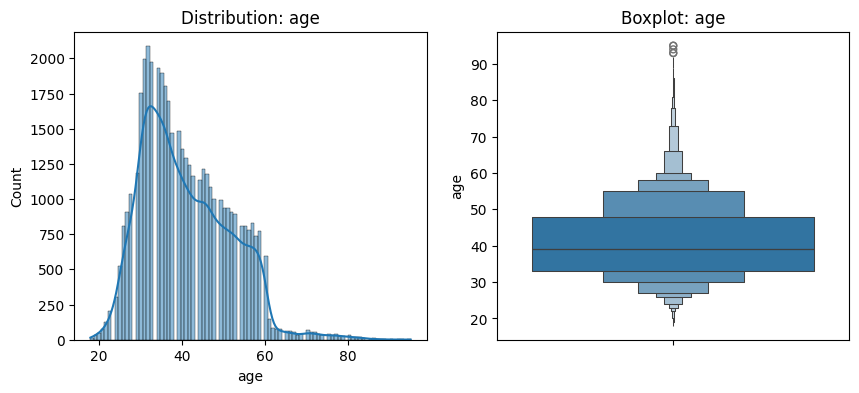

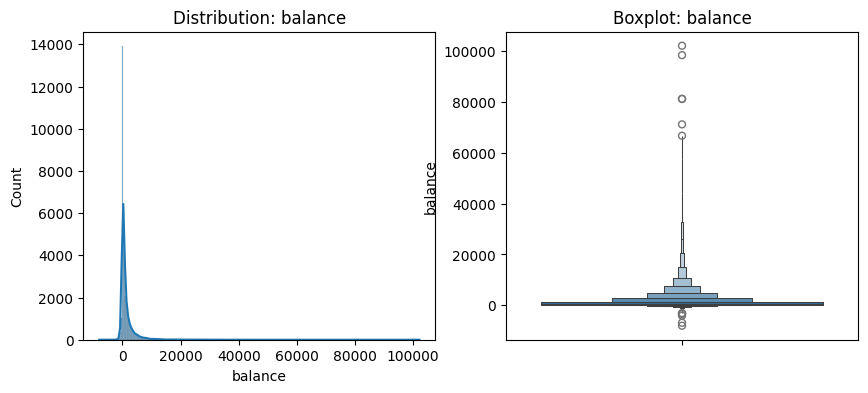

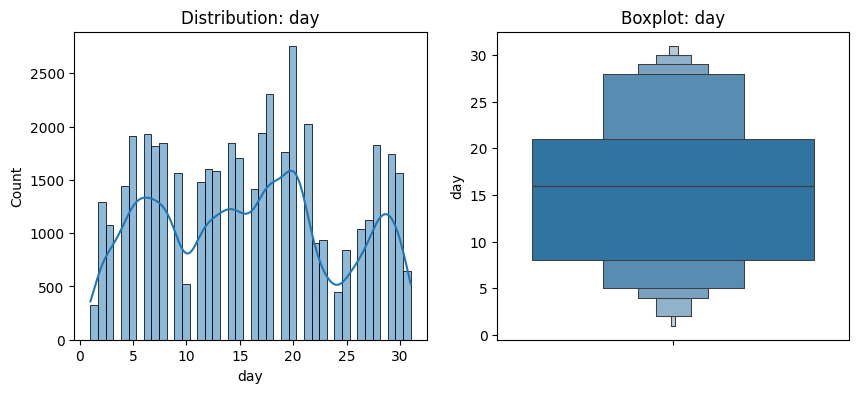

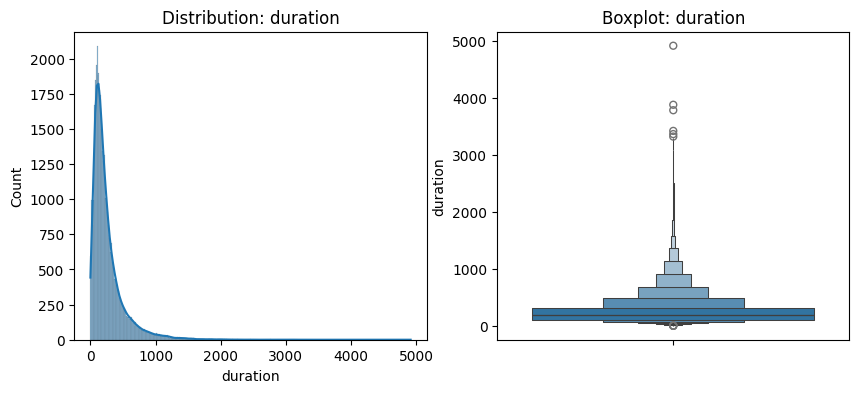

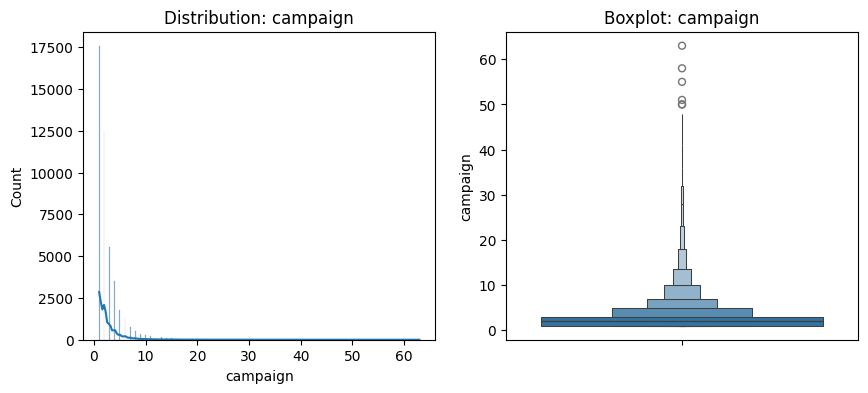

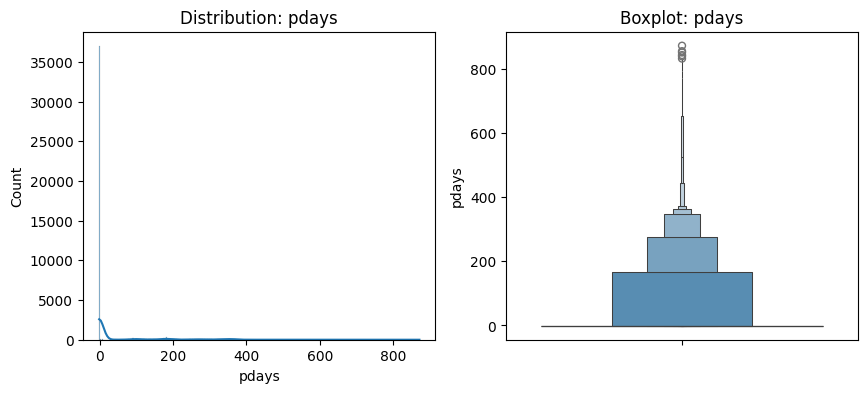

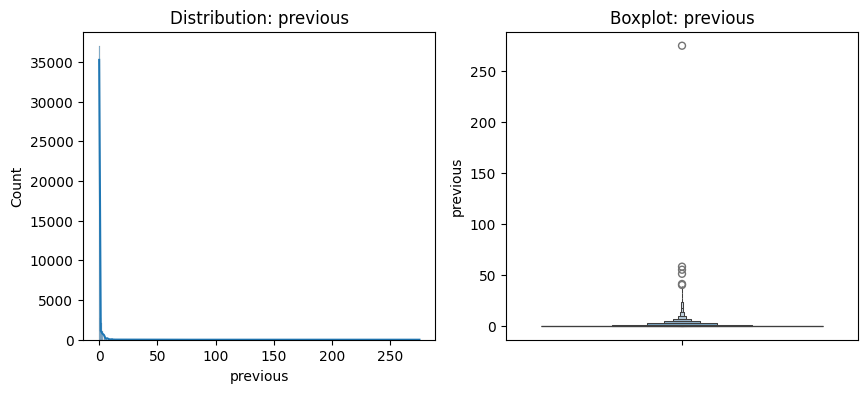

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=['int', 'float'])

for col in num_cols:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')

    plt.subplot(1,2,2)
    sns.boxenplot(df[col])
    plt.title(f'Boxplot: {col}')

    plt.show()

In [8]:
import numpy as np

df['is_contated'] = (df['pdays'] == -1).astype(int)

df['total_contacts'] = df['campaign'] + df['previous']

df['interaction_intensity'] = df['campaign'] / (df['total_contacts'] + 1)

df['balance_logmod'] = np.sign(df['balance']) * np.log1p(np.abs(df['balance']))

cols_to_remove = ['previous', 'balance', 'campaign', 'duration', 'pdays']

df = df.drop(columns=[c for c in cols_to_remove if c in df.columns])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_for_normalize = list(df.select_dtypes(include=['int','float']))

cols_for_normalize.remove('is_contated')

df[cols_for_normalize] = scaler.fit_transform(df[cols_for_normalize])

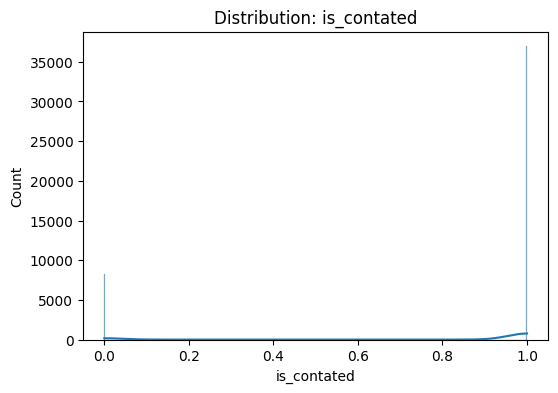

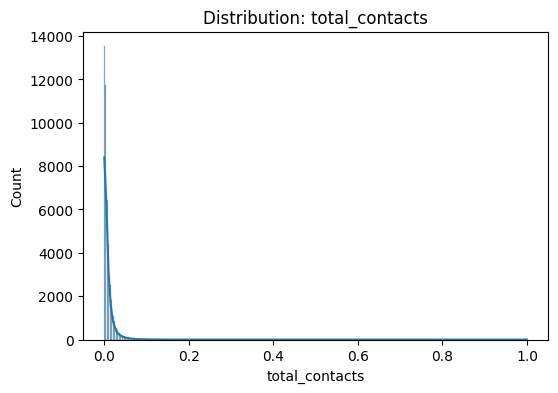

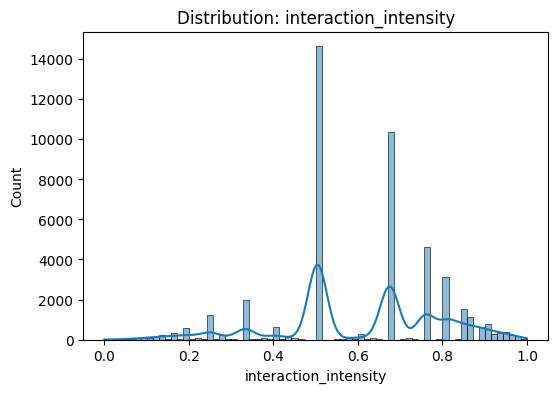

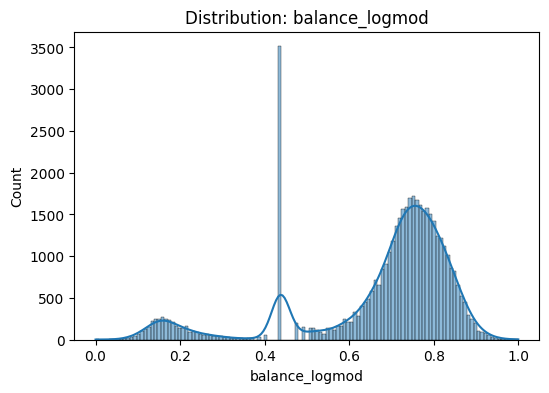

In [10]:
cols_after_engennier = ['is_contated', 'total_contacts', 'interaction_intensity', 'balance_logmod']

for col in cols_after_engennier:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')

In [11]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

map_binare = ['default', 'loan', 'housing']
df[map_binare] = (df[map_binare] == 'yes').astype(int)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cols_for_ohe = ['job', 'marital', 'contact', 'month', 'poutcome']
data_ohe = ohe.fit_transform(df[cols_for_ohe])
new_columns_ohe = ohe.get_feature_names_out(cols_for_ohe)
encoded_ohe = pd.DataFrame(data=data_ohe, columns=new_columns_ohe, index=df.index)

ord = OrdinalEncoder()
cols_for_ord = ['education']
data_ord = ord.fit_transform(df[cols_for_ord])
new_columns_ord = ord.get_feature_names_out(cols_for_ord)
encoded_ord = pd.DataFrame(data=data_ord, columns=new_columns_ord, index=df.index)

cols_to_drop = cols_for_ohe + cols_for_ord

df = pd.concat(
    [df.drop(cols_to_drop, axis=1), encoded_ohe, encoded_ord], axis=1
)

In [12]:
df.head()

,age,default,housing,loan,day,Class,is_contated,total_contacts,interaction_intensity,balance_logmod,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,education
0,0.519481,0,1,0,0.133333,1,1,0.0,0.504314,0.811751,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0.337662,0,1,0,0.133333,1,1,0.0,0.504314,0.603736,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.194805,0,1,1,0.133333,1,1,0.0,0.504314,0.491545,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.376623,0,1,0,0.133333,1,1,0.0,0.504314,0.794574,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
4,0.194805,0,0,0,0.133333,1,1,0.0,0.504314,0.471789,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


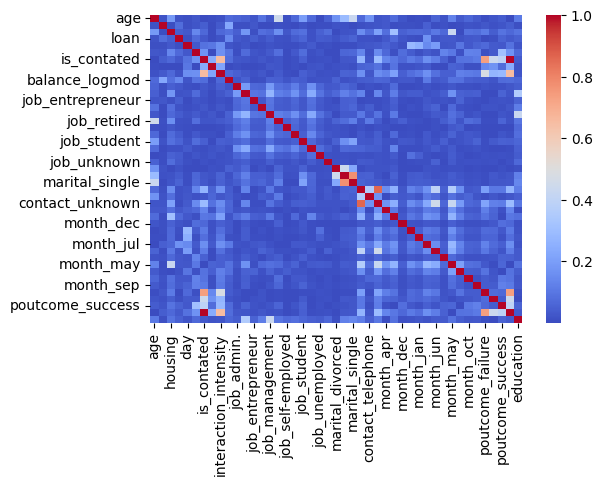

In [13]:
corr = df.corr().abs()

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

In [14]:
def drop_correlated_features(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    df_reduced = df.drop(columns=to_drop)
    print(f"Original Features : {df.shape[1]}")
    print(f"Removed Features ({len(to_drop)}): {to_drop}")
    
    return df_reduced

df_clean = drop_correlated_features(df)

Original Features : 45
Removed Features (2): ['contact_unknown', 'poutcome_unknown']


## 3. Modelagem

Foram treinados e comparados dois modelos de famílias distintas:

1.  **Random Forest (Ensemble):**
    * **Por que:** Robusto para dados tabulares, lida bem com outliers e fornece a importância das variáveis.
    * **Configuração:** `class_weight='balanced'`, `n_estimators=200`.

2.  **K-Nearest Neighbors - KNN (Baseado em Distância):**
    * **Por que:** Útil para encontrar padrões locais de similaridade entre clientes.
    * **Configuração:** `weights='distance'` (incrementa um peso significativo a vizinhos muito próximos).

In [15]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns='Class')
y = df_clean['Class'].map({'1': 0, '2': 1})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

rfc_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

rfc_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

y_pred_rfc = rfc_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)


In [17]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rfc_model.feature_importances_
}).sort_values('importance', ascending=False)

display(feature_importances.head(10))

,feature,importance
8,balance_logmod,0.161153
0,age,0.142382
4,day,0.121365
7,interaction_intensity,0.070840
6,total_contacts,0.051668
40,poutcome_success,0.038996
41,education,0.037835
24,contact_cellular,0.032495
2,housing,0.032169
5,is_contated,0.020107


## 4. Avaliação Comparativa

Os resultados dos modelos foram:

| Modelo | Accuracy | Precision | Recall | F1-Score |
| :--- | :--- | :--- | :--- | :--- |
| Random Forest | **89.2%** | **66.2%** | 22.4% | 33.5% |
| **KNN** | 87.9% | 49.8% | **25.7%** | **33.9%** |

**Análise:**
* Embora o Random Forest tenha maior precisão, o **KNN venceu no Recall e F1-Score**.
* Como o objetivo de negócio é maximizar os Verdadeiros Positivos, ou seja, capturar os "futuros compradores", o KNN provou ser mais capaz de identificar a classe minoritária.

**Matriz de Confusão (KNN):**
* **Verdadeiros Negativos:** O modelo evitou milhares de ligações inúteis.
* **Verdadeiros Positivos:** O modelo capturou 25% de todo o potencial de vendas ligando para uma fração da base.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(name_model, y_true, y_pred):
    return {
        'Model': name_model,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

metrics_rfc = calculate_metrics("RFC", y_test, y_pred_rfc)
metrics_knn = calculate_metrics("KNN", y_test, y_pred_knn)

df_comparative = pd.DataFrame([metrics_rfc, metrics_knn])

display(df_comparative)

,Model,Accuracy,Precision,Recall,F1-Score
0,RFC,0.892624,0.662162,0.224565,0.335387
1,KNN,0.879133,0.498227,0.257562,0.339577


In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, y_true, y_pred ):
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,4))
    ax = sns.heatmap(cf_matrix,annot=True, fmt='d', cmap='coolwarm', linewidths=.10, cbar=False)

    ax.set_ylabel('Verdadeiro', fontsize=12)
    ax.set_xlabel('Predito', fontsize=12)
    ax.set_title(f'Matriz de Confusão: {model}', fontsize=14)

    ax.xaxis.set_ticklabels(['Não', 'Sim'])
    ax.yaxis.set_ticklabels(['Não', 'Sim'])

    tn, fp, fn, tp = cf_matrix.ravel()

    print(f"""
{55*'-'}
    Verdadeiros Positivos (Acertos de Venda): {tp}
    Verdadeiros Negativos (Economia de Ligações): {tn}
    Falsos Negativos (Oportunidades Perdidas): {fn}
    Falsos Positivos (Custo Operacional Extra): {fp}
{55*'-'}""")


-------------------------------------------------------
    Verdadeiros Positivos (Acertos de Venda): 245
    Verdadeiros Negativos (Economia de Ligações): 7827
    Falsos Negativos (Oportunidades Perdidas): 846
    Falsos Positivos (Custo Operacional Extra): 125
-------------------------------------------------------


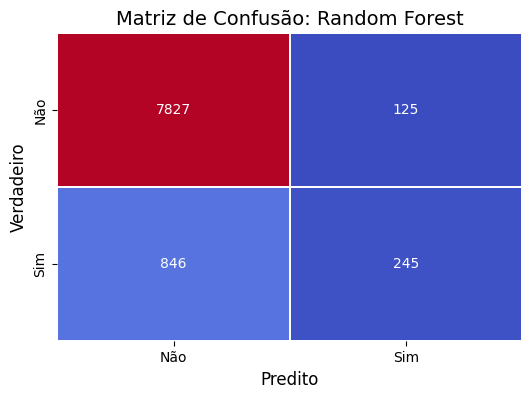

In [20]:
plot_confusion_matrix("Random Forest", y_test, y_pred_rfc)


-------------------------------------------------------
    Verdadeiros Positivos (Acertos de Venda): 281
    Verdadeiros Negativos (Economia de Ligações): 7669
    Falsos Negativos (Oportunidades Perdidas): 810
    Falsos Positivos (Custo Operacional Extra): 283
-------------------------------------------------------


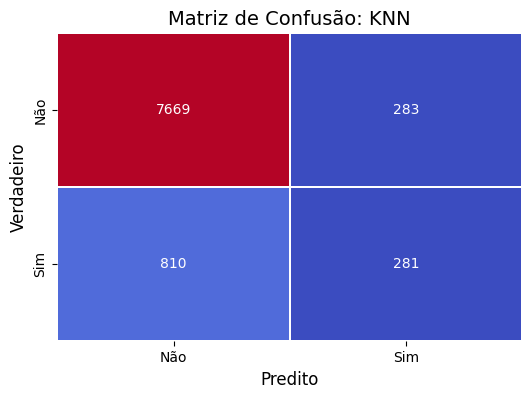

In [21]:
plot_confusion_matrix("KNN", y_test, y_pred_knn)